## Final Project Submission

Please fill out:
* Student name: Mwangi Wambugu, Brian Orwa, Julius Kagety, Dennis Kimani, Amina Hagi, Emmanuel Rono.
* Student pace: full time
* Scheduled project review date/time:  26/10/2023
* Instructor name: 
* Blog post URL:


# AN OVERVIEW OF HOUSES IN KING COUNTY FOR REAL ESTATE STAKEHOLDER ENGAGEMENT

# Introduction

Kings county is a county located in the USA in Washington state. It has population of 2,045,756 as at 2015. The county has an overall square foot of 5,975km sq.It is the most populous county in the state and includes the city of Seattle, which is the largest city in Washington. King County is in the western part of Washington and is known for its urban areas, cultural attractions, and natural beauty like views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river and creek. <b> 

It plays a significant role in the economic and cultural life of the Pacific Northwest.King County, Washington, occupies a prominent role in the heart of the Pacific Northwest, acting as a bustling economic and cultural nucleus. Home to global giants such as Amazon, Microsoft, and Starbucks, the county's largest city, Seattle, thrives as a technological powerhouse, driving innovation and entrepreneurship throughout the region. With a vibrant tech sector, the area serves as a beacon for startups and venture capitalists, making it the "Tech Capital of the Pacific Northwest.<b>

Beyond the business landscape, King County boasts prestigious educational institutions, including the University of Washington, nurturing research, innovation, and a skilled workforce. The county's rich cultural life is an integral part of its identity, offering a diverse array of arts, music, and outdoor recreational activities. The Port of Seattle further cements the county's global connectivity, while its progressive values make it a leader in sustainability, social issues, and quality of life.This dynamic county is known for its unwavering commitment to progress and a high quality of life. The presence of industry giants, academic excellence, and a thriving cultural scene make King County a compelling region in the Pacific Northwest. Its stunning natural landscapes and global connectivity, through the Port of Seattle, underscore its significance in the broader context of the region. It continues to shape the future through innovation, research, and a welcoming environment that celebrates diversity and creativity, making King County an essential contributor to the economic and cultural vibrancy of the Pacific Northwest.



# Business Understanding

Due to King county being the most populated area in Wahington state it provides a lucrative investment hub for real estate. This can be attractive due to its captivating views and seattle being a city hence the demand for housing.The real estate industry in King County, Washington, is a dynamic and ever-evolving sector that mirrors the county's rapid economic growth and cultural diversity. Nestled in the heart of the Pacific Northwest, King County's real estate market has garnered significant attention, thanks to the influence of tech giants like Amazon and Microsoft, which have fueled a demand for housing. Seattle, the county's largest city, has experienced substantial population growth, leading to a robust housing market. The city's skyline is continually transforming, with numerous high-rise condominiums and apartments catering to urban dwellers, while charming suburban neighborhoods offer a quieter, family-friendly atmosphere. King County's real estate market also features a variety of architectural styles, from historic homes to modern eco-friendly constructions, reflecting the area's progressive values and emphasis on sustainability.

The real estate market in King County, WA, is marked by both opportunities and challenges. While the county's flourishing tech sector attracts young professionals and investors, it has also led to increased property values and affordability concerns. This has prompted the government and local organizations to focus on affordable housing initiatives. Additionally, King County's proximity to natural wonders like the Puget Sound and the Cascade Range has made it a hotspot for outdoor enthusiasts, further boosting the demand for properties near scenic landscapes. As the county continues to flourish economically and culturally, the real estate industry remains a critical barometer of its growth and reflects its unique blend of modern urban living and natural beauty.

# Data understanding

The dataset provides a comprehensive understanding of various attributes related to houses in King County, Washington. The 'id' serves as a unique identifier for each house, enabling precise tracking. The 'date' column reveals when the house was sold, offering insights into seasonal trends. The 'price' column represents the sale price, which is the target variable for prediction, reflecting the real estate market's fluctuations.

The dataset includes several vital features such as the number of 'bedrooms' and 'bathrooms,' which dictate the living space's size. 'sqft_living' and 'sqft_lot' denote the square footage of the house's interior and lot size, while 'floors' indicates the number of levels in each house. 'Waterfront' presents whether the property enjoys the charm of a waterfront location. 'View' categorizes the quality of views, providing an important aesthetic perspective. The 'condition' and 'grade' attributes assess the overall state and construction quality, respectively. 'Sqft_above' and 'sqft_basement' partition the living area between above-ground and basement space. The 'yr_built' and 'yr_renovated' features capture the house's age and any remodeling history. 'Zipcode' records the postal code, and 'lat' and 'long' represent the geographical coordinates. Additionally, 'sqft_living15' and 'sqft_lot15' delineate the living space and lot size of the nearest 15 neighbors, offering insights into the neighborhood's housing characteristics. This dataset lays the foundation for comprehensive analysis and predictive modeling in the real estate domain.<b>



# Objectives

The main objective of this study is to identify the factors that influence house prices in King County, Washington. This overarching goal is supported by several specific objectives, including determining the optimal month for both selling and purchasing houses in the county to maximize profitability. Additionally, the study aims to establish the periods during which most houses were constructed, shedding light on the area's real estate development history. Furthermore, it seeks to identify the most prevalent types of houses in the county, helping real estate professionals and buyers make informed decisions. Lastly, the study will investigate the common budget range within which most buyers in King County operate, providing valuable insights for market participants.

In [15]:
# Importing relevant libraries.

# Data manipulation
import pandas as pd 

# Numerical operations
import numpy as np   

# Data visualization and Plotting
import seaborn as sns 
import matplotlib.pyplot as plt  

# Scientific and statistical functions/Statistical modeling and analysis
from scipy import stats 
import statsmodels.api as sm  
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error






In [16]:
# Serializalization  
df=pd.read_csv('data/kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Data Cleaning


From the observed data we aim to look at:<b>

1. To look for type casted datatypes
2. To look for missing values
3. We are looking for outliers

By addressing these aspects, we ensure a more robust and accurate analysis of the dataset.


In [17]:
# Describing data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [18]:
# Changing date to datetime
df['date']=pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  object        
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

In [19]:
# Identifying mising values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [20]:
# Dropping rows with missing values
columns_to_check = ['waterfront', 'yr_renovated','view']
df.dropna(subset=columns_to_check, inplace=True)
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,11 Excellent,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,7 Average,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,2015-02-19,475000.0,3,2.50,1310,1294,2.0,NO,NONE,...,8 Good,1180,130.0,2008,0.0,98116,47.5773,-122.409,1330,1265
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007


In [21]:
# Validating missing values
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [22]:
# Replacing missing values
df.replace("?", np.nan, inplace=True)
df.fillna(0, inplace=True)
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,11 Excellent,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,7 Average,1715,0,1995,0.0,98003,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,2015-02-19,475000.0,3,2.50,1310,1294,2.0,NO,NONE,...,8 Good,1180,130.0,2008,0.0,98116,47.5773,-122.409,1330,1265
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007


## Exploratory Data Analysis

This is an analysis we look into the individual componenets of the data. The EDA process aims to provide an initial understanding of the data's distribution, central tendencies, and variations, laying the foundation for more in-depth analyses and modeling. It is a critical phase in the data analysis pipeline that helps uncover patterns, relationships, and potential factors influencing house prices in King County.


In [23]:
# Total number of houses without basement
(df.sqft_basement == '0.0').sum()

9362

In [24]:
#Number of houses with unique floor values
df['floors'].value_counts().to_frame()

,floors
1.0,7777
2.0,6049
1.5,1374
3.0,439
2.5,117
3.5,6


In [25]:
# Total number of houses on a waterfront 
(df.waterfront == 'YES').sum()

120

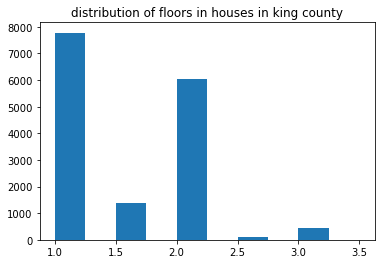

In [26]:
#Distribution of number of floors in a house in the data

plt.hist(x = df['floors'])
plt.title("distribution of floors in houses in king county")
plt.show()

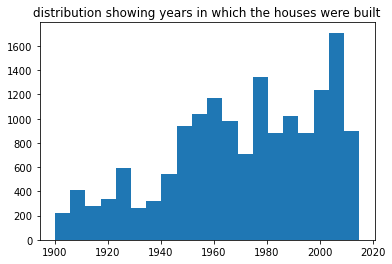

In [27]:
#Distribution and trend in years in which king county houses were built according to the data

plt.hist(x = df['yr_built'], bins = 20)
plt.title("distribution showing years in which the houses were built")
plt.show()

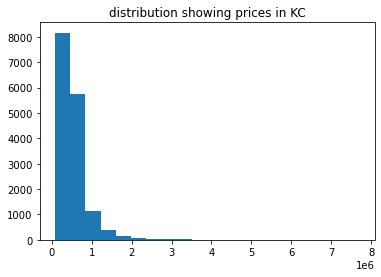

In [28]:
# Distribution of prices in king county
plt.hist(x = df['price'], bins = 20)
plt.title("distribution showing prices in KC")
plt.show()

In [29]:
# Changing date to months
df['month'] = df['date'].dt.month
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,12
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930,5
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,1715,0,1995,0.0,98003,47.3097,-122.327,2238,6819,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,2015-02-19,475000.0,3,2.50,1310,1294,2.0,NO,NONE,...,1180,130.0,2008,0.0,98116,47.5773,-122.409,1330,1265,2
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,5
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,2
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,6


In [30]:
# Replacing figures of the month with their corresponding month of the year
months_in_year = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}
df['month'] = df['month'].replace(months_in_year)
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,December
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,December
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,February
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930,May
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,1715,0,1995,0.0,98003,47.3097,-122.327,2238,6819,June
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,2015-02-19,475000.0,3,2.50,1310,1294,2.0,NO,NONE,...,1180,130.0,2008,0.0,98116,47.5773,-122.409,1330,1265,February
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,May
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,February
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,June
